# Donkey, horse, and zebra image classification using Kaggle image dataset and Transfer Learning Xception model

In [119]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

In [120]:
DATADIR = 'C://Users//kusha//Desktop//horse_donkey_zebra_predixtion//train'
DATADIR_TEST = 'C://Users//kusha//Desktop//horse_donkey_zebra_predixtion//test'
CATEGORIES = ['donkey', 'horse', 'zebra']

IMG_SIZE = 224

In [121]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest',
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
    validation_split=0.2)

## Loading training, validation and testing images

In [122]:
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    DATADIR,
    target_size=(224, 224),
    batch_size=batch_size,
    shuffle=True,
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    DATADIR,
    target_size=(224, 224),
    batch_size=batch_size,
    shuffle=True,
    subset='validation')

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input).flow_from_directory(
    DATADIR_TEST, 
    target_size=(224,224), 
    shuffle= False,
    batch_size = batch_size)

Found 809 images belonging to 3 classes.
Found 200 images belonging to 3 classes.
Found 256 images belonging to 3 classes.


In [123]:
class_names = train_generator.class_indices

In [124]:
class_names

{'donkey': 0, 'horse': 1, 'zebra': 2}

In [125]:
class_names = ['donkey', 'horse', 'zebra']

## Counting the number of instances in each class

In [126]:
print ("In train_generator ")
for cls in range(len (train_generator.class_indices)):
    print(class_names[cls],":\t",list(train_generator.classes).count(cls))
print ("") 

print ("In validation_generator ")
for cls in range(len (validation_generator.class_indices)):
    print(class_names[cls],":\t",list(validation_generator.classes).count(cls))
print ("") 

print ("In test_generator ")
for cls in range(len (test_generator.class_indices)):
    print(class_names[cls],":\t",list(test_generator.classes).count(cls))

In train_generator 
donkey :	 320
horse :	 308
zebra :	 181

In validation_generator 
donkey :	 79
horse :	 76
zebra :	 45

In test_generator 
donkey :	 100
horse :	 96
zebra :	 60


## Loading of pretrained Xception model and replacing top layers with layers needed for our classification

In [127]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(3, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

## Creating callback for saving only the model performing best on validation set

In [128]:
modelName= "inception"
#save the best weights over the same file with the model name

#filepath="checkpoints/"+modelName+"_bestweights.hdf5"
filepath=modelName+"_bestweights.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

## Freezing of layers and training top layers for few epochs 

In [129]:
for layer in base_model.layers:
    layer.trainable = False

In [92]:
train_generator.reset()
validation_generator.reset()

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_generator, validation_data=validation_generator, callbacks=callbacks_list, epochs=5)

Epoch 1/5
26/26 [==============================] - ETA: 0s - loss: 1.7026 - accuracy: 0.7145
Epoch 1: val_accuracy improved from -inf to 0.93500, saving model to inception_bestweights.hdf5
26/26 [==============================] - 13s 417ms/step - loss: 1.7026 - accuracy: 0.7145 - val_loss: 0.5463 - val_accuracy: 0.9350
Epoch 2/5
26/26 [==============================] - ETA: 0s - loss: 0.7871 - accuracy: 0.8900
Epoch 2: val_accuracy did not improve from 0.93500
26/26 [==============================] - 10s 369ms/step - loss: 0.7871 - accuracy: 0.8900 - val_loss: 0.3602 - val_accuracy: 0.9150
Epoch 3/5
26/26 [==============================] - ETA: 0s - loss: 0.5918 - accuracy: 0.9048
Epoch 3: val_accuracy did not improve from 0.93500
26/26 [==============================] - 10s 374ms/step - loss: 0.5918 - accuracy: 0.9048 - val_loss: 0.5266 - val_accuracy: 0.9250
Epoch 4/5
26/26 [==============================] - ETA: 0s - loss: 0.5508 - accuracy: 0.8986
Epoch 4: val_accuracy did not impr

## Then we unfreeze some layers and train again for few more epochs with lower learning rate

In [93]:
for layer in base_model.layers[56:]:
    layer.trainable = True

In [94]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_generator, validation_data=validation_generator, callbacks=callbacks_list, epochs=10)

Epoch 1/10
26/26 [==============================] - ETA: 0s - loss: 0.3975 - accuracy: 0.8690
Epoch 1: val_accuracy improved from 0.93500 to 0.94000, saving model to inception_bestweights.hdf5
26/26 [==============================] - 15s 438ms/step - loss: 0.3975 - accuracy: 0.8690 - val_loss: 0.4547 - val_accuracy: 0.9400
Epoch 2/10
26/26 [==============================] - ETA: 0s - loss: 0.2010 - accuracy: 0.9345
Epoch 2: val_accuracy did not improve from 0.94000
26/26 [==============================] - 10s 388ms/step - loss: 0.2010 - accuracy: 0.9345 - val_loss: 0.3289 - val_accuracy: 0.9350
Epoch 3/10
26/26 [==============================] - ETA: 0s - loss: 0.1264 - accuracy: 0.9567
Epoch 3: val_accuracy improved from 0.94000 to 0.96500, saving model to inception_bestweights.hdf5
26/26 [==============================] - 10s 397ms/step - loss: 0.1264 - accuracy: 0.9567 - val_loss: 0.1515 - val_accuracy: 0.9650
Epoch 4/10
26/26 [==============================] - ETA: 0s - loss: 0.087

## Now we load the best model weights and train again for few more epochs with even lower learning rate, just to see if it's possible to get better performance

In [96]:
model.load_weights("C://Users//kusha//Desktop//horse_donkey_zebra_predixtion//inception_bestweights.hdf5")

In [97]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_generator, validation_data=validation_generator, callbacks=callbacks_list, epochs=5)

Epoch 1/5
26/26 [==============================] - ETA: 0s - loss: 0.0876 - accuracy: 0.9580
Epoch 1: val_accuracy did not improve from 0.96500
26/26 [==============================] - 14s 416ms/step - loss: 0.0876 - accuracy: 0.9580 - val_loss: 0.1104 - val_accuracy: 0.9650
Epoch 2/5
26/26 [==============================] - ETA: 0s - loss: 0.0585 - accuracy: 0.9802
Epoch 2: val_accuracy did not improve from 0.96500
26/26 [==============================] - 10s 381ms/step - loss: 0.0585 - accuracy: 0.9802 - val_loss: 0.1426 - val_accuracy: 0.9600
Epoch 3/5
26/26 [==============================] - ETA: 0s - loss: 0.0683 - accuracy: 0.9790
Epoch 3: val_accuracy did not improve from 0.96500
26/26 [==============================] - 10s 392ms/step - loss: 0.0683 - accuracy: 0.9790 - val_loss: 0.1075 - val_accuracy: 0.9550
Epoch 4/5
26/26 [==============================] - ETA: 0s - loss: 0.0556 - accuracy: 0.9815
Epoch 4: val_accuracy did not improve from 0.96500
26/26 [=====================

## Now we are ready to load our model and see the performance on validation and test sets

In [134]:
model.load_weights("C://Users//kusha//Desktop//horse_donkey_zebra_predixtion//inception_bestweights.hdf5")
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [135]:
validation_generator.reset()
score = model.evaluate(validation_generator)
print("For validation data set; Loss: ",score[0]," Accuracy: ", score[1])

7/7 [==============================] - 3s 219ms/step - loss: 0.1310 - accuracy: 0.9600
For validation data set; Loss:  0.13100701570510864  Accuracy:  0.9599999785423279


In [136]:
test_generator.reset()
score = model.evaluate(test_generator)
print("For test data set; Loss: ",score[0]," Accuracy: ", score[1])

8/8 [==============================] - 1s 132ms/step - loss: 0.3662 - accuracy: 0.9414
For test data set; Loss:  0.36623674631118774  Accuracy:  0.94140625


#### It has 96% accuracy on validation set and 94% accuracy on test set

## Now we test the model and use metrics to see how it performs with respect to each class

In [137]:
predictions = model.predict(test_generator)

8/8 [==============================] - 2s 158ms/step


In [138]:
predictions

array([[4.30612676e-02, 4.21166003e-01, 5.35772741e-01],
       [9.99989748e-01, 9.95801838e-06, 1.95088091e-07],
       [9.99223590e-01, 7.76281464e-04, 1.42973818e-07],
       [9.98071790e-01, 1.91717420e-03, 1.10430374e-05],
       [9.97440934e-01, 2.52800318e-03, 3.10701871e-05],
       [1.00000000e+00, 4.97411676e-08, 5.32497921e-08],
       [9.98649776e-01, 1.34813390e-03, 2.09731456e-06],
       [9.99997258e-01, 1.03799050e-06, 1.70371982e-06],
       [9.52304780e-01, 4.64812890e-02, 1.21392449e-03],
       [9.98794913e-01, 1.15428737e-03, 5.06930774e-05],
       [2.01241783e-05, 9.99979615e-01, 2.31367792e-07],
       [1.00000000e+00, 4.48449011e-09, 6.58122756e-09],
       [7.83900578e-06, 9.99992132e-01, 8.73404959e-10],
       [9.99996901e-01, 3.06729999e-06, 1.65853731e-08],
       [9.99994636e-01, 5.21554193e-06, 8.31010141e-08],
       [7.86030233e-01, 2.13969499e-01, 2.59615604e-07],
       [9.91617143e-01, 8.37704632e-03, 5.78443405e-06],
       [9.99998331e-01, 1.43395

In [139]:
predicted_class=np.argmax(predictions,axis=1)

In [140]:
accuracy_score(test_generator.classes, predicted_class)

0.94140625

#### Accuracy is 94% as we saw earlier

In [141]:
print(classification_report(test_generator.classes, predicted_class))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94       100
           1       0.90      0.98      0.94        96
           2       0.95      0.97      0.96        60

    accuracy                           0.94       256
   macro avg       0.94      0.95      0.94       256
weighted avg       0.94      0.94      0.94       256



#### Each class has high precision and recall, 90% and higher, so it means it separates well between these three types of animals

## Now we crate simple functions for preprocessing the images I found in internet and make predicitons on them

In [177]:
def preprocess(photo):

    preprocess = tf.keras.Sequential([
        tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
        tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
    ])
    
    photo = preprocess(photo)
    
    photo = np.reshape(photo, (1, 224, 224, 3))
    
    return photo

In [183]:
def predict(photo):
    photo = preprocess(photo)
    
    print('This is ' + class_names[np.argmax(model.predict(photo))])

In [184]:
photo = 'C://Users//kusha//Desktop//donkey1.jpg'

In [185]:
photo = cv2.imread(photo)

[]

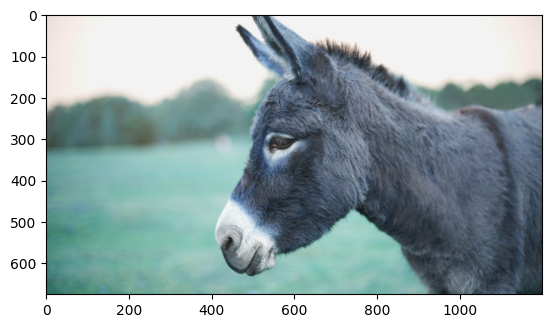

In [186]:
plt.imshow(photo)
plt.plot()

In [187]:
predict(photo)

1/1 [==============================] - 0s 17ms/step
This is donkey


In [191]:
photo = 'C://Users//kusha//Desktop//donkey3.jfif'

[]

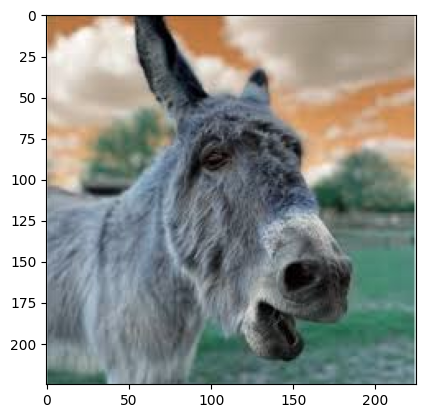

In [192]:
photo = cv2.imread(photo)
plt.imshow(photo)
plt.plot()

In [193]:
predict(photo)

1/1 [==============================] - 0s 22ms/step
This is donkey


[]

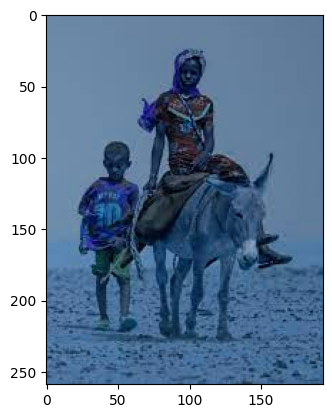

In [195]:
photo = 'C://Users//kusha//Desktop//donkey2.jfif'
photo = cv2.imread(photo)
plt.imshow(photo)
plt.plot()

In [196]:
predict(photo)

1/1 [==============================] - 0s 23ms/step
This is horse


### It says this is the horse, but it is donkey, so it doesn't classify well when it has other objects on the image

[]

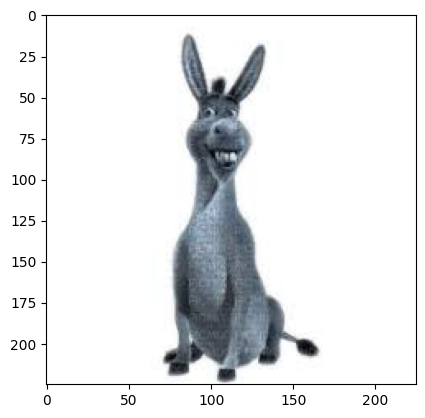

In [199]:
photo = 'C://Users//kusha//Desktop//donkey4.jfif'
photo = cv2.imread(photo)
plt.imshow(photo)
plt.plot()

In [200]:
predict(photo)

1/1 [==============================] - 0s 20ms/step
This is donkey


### It classifies well even for cartoon characters

## Now lets try for horses

[]

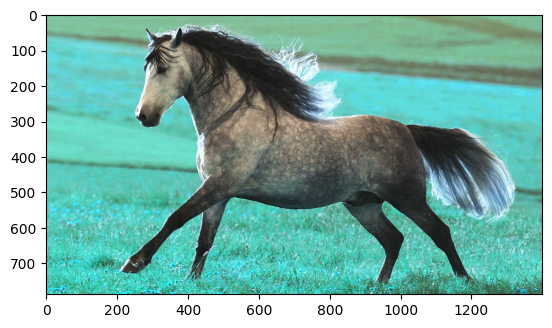

In [201]:
photo = 'C://Users//kusha//Desktop//horse1.jpg'
photo = cv2.imread(photo)
plt.imshow(photo)
plt.plot()

In [202]:
predict(photo)

1/1 [==============================] - 0s 21ms/step
This is horse


[]

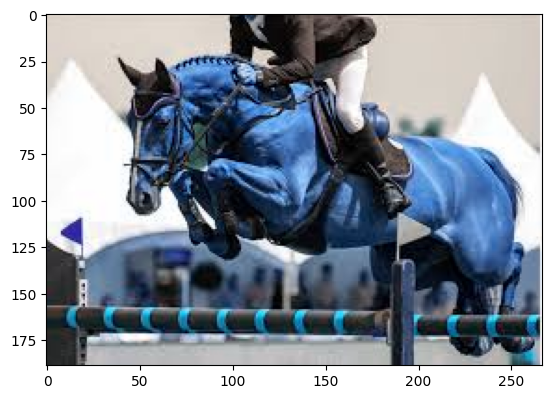

In [203]:
photo = 'C://Users//kusha//Desktop//horse2.jfif'
photo = cv2.imread(photo)
plt.imshow(photo)
plt.plot()

In [204]:
predict(photo)

1/1 [==============================] - 0s 22ms/step
This is horse


[]

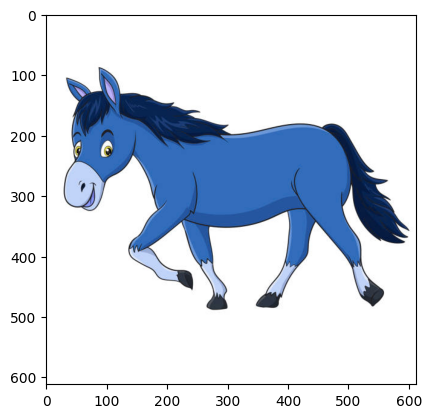

In [206]:
photo = 'C://Users//kusha//Desktop//horse3.jpg'
photo = cv2.imread(photo)
plt.imshow(photo)
plt.plot()

In [207]:
predict(photo)

1/1 [==============================] - 0s 20ms/step
This is horse


## Classifies well for cartoon horses

[]

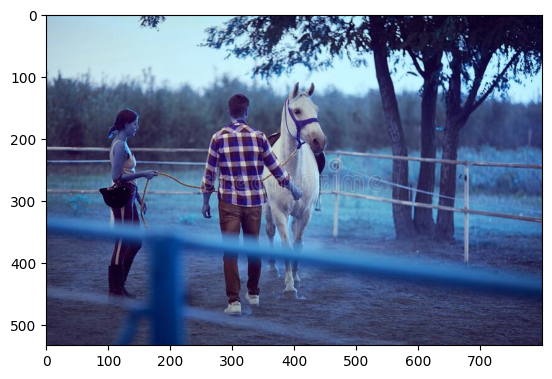

In [211]:
photo = 'C://Users//kusha//Desktop//horse4.jpg'
photo = cv2.imread(photo)
plt.imshow(photo)
plt.plot()

In [209]:
predict(photo)

1/1 [==============================] - 0s 20ms/step
This is horse


## Works well for when there are human on the photo and in front of the horse

## Now let's check for zebra

[]

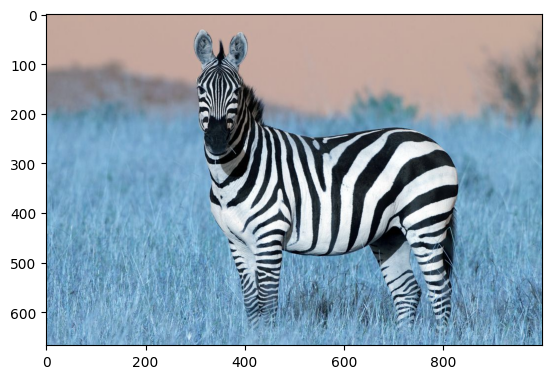

In [212]:
photo = 'C://Users//kusha//Desktop//zebra1.jpg'
photo = cv2.imread(photo)
plt.imshow(photo)
plt.plot()

In [213]:
predict(photo)

1/1 [==============================] - 0s 21ms/step
This is zebra


[]

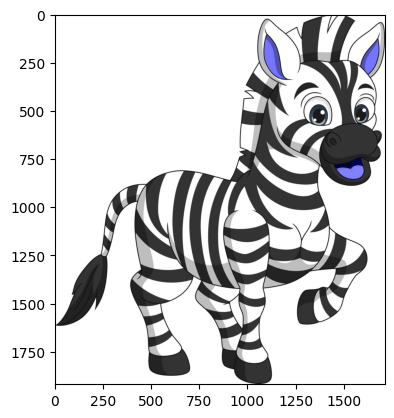

In [214]:
photo = 'C://Users//kusha//Desktop//zebra2.jpg'
photo = cv2.imread(photo)
plt.imshow(photo)
plt.plot()

In [215]:
predict(photo)

1/1 [==============================] - 0s 19ms/step
This is zebra


[]

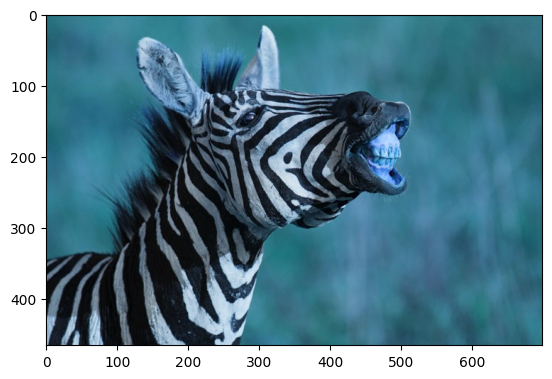

In [216]:
photo = 'C://Users//kusha//Desktop//zebra3.jpg'
photo = cv2.imread(photo)
plt.imshow(photo)
plt.plot()

In [217]:
predict(photo)

1/1 [==============================] - 0s 21ms/step
This is zebra


[]

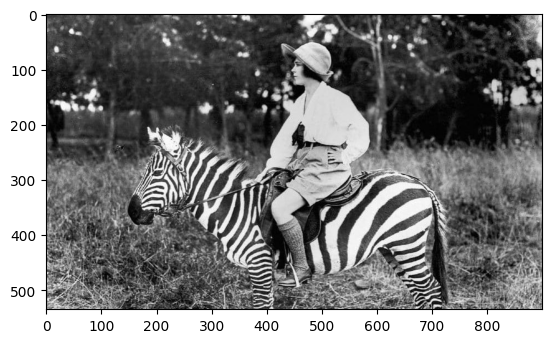

In [219]:
photo = 'C://Users//kusha//Desktop//zebra4.jpg'
photo = cv2.imread(photo)
plt.imshow(photo)
plt.plot()

In [220]:
predict(photo)

1/1 [==============================] - 0s 20ms/step
This is zebra


[]

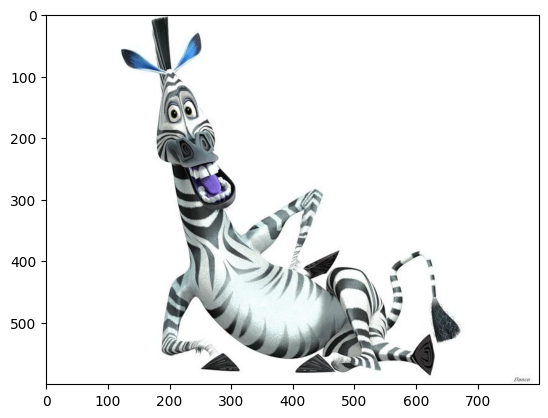

In [221]:
photo = 'C://Users//kusha//Desktop//zebra5.jpg'
photo = cv2.imread(photo)
plt.imshow(photo)
plt.plot()

In [222]:
predict(photo)

1/1 [==============================] - 0s 19ms/step
This is zebra


## For zebra it classified correctly all the images it was fed

## Summary: classifier works well, but sometimes it confuses donkey with a horse, probably it is because they are alike, they share a lot of similar features, sometimes horse can have the same color as donkey. The best performance in terms of the metrics has zebra, but it might be obvious, as it has a lot of features that can discriminate it from horse and donkey, such as black stripes over the body and specific mane